# Phase 1: Descriptive Statistics

**Swiss Ballot Chatbot Study - Measurement Analysis**

2×2 Factorial Design: Transparency (T0/T1) × Control (C0/C1)

| Condition | Transparency | Control |
|-----------|--------------|--------|
| A | T0 (Low) | C0 (Low) |
| B | T1 (High) | C0 (Low) |
| C | T0 (Low) | C1 (High) |
| D | T1 (High) | C1 (High) |

---

## Setup & Configuration

In [1]:
# Import required libraries
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Figure size defaults
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Import functions from phase1_descriptive_statistics.py
from phase1_descriptive_statistics import (
    AnalysisConfig,
    get_db_connection,
    load_participant_data,
    prepare_variables,
    compute_sample_flow,
    compute_n_per_condition,
    compute_donation_rates,
    compute_demographics,
    compute_manipulation_checks,
    compute_risk_trust,
    compute_dashboard_frequencies,
    compute_q14_response_rate,
    wilson_ci
)

print("Analysis functions imported successfully!")

Analysis functions imported successfully!


In [3]:
# ============================================================
# CONFIGURATION: Select participant type
# ============================================================
# Set to True for AI participants, False for human participants
IS_AI_PARTICIPANT = True

# Initialize configuration
config = AnalysisConfig(is_ai_participant=IS_AI_PARTICIPANT)

participant_label = "AI Test Users" if IS_AI_PARTICIPANT else "Human Participants"
print(f"Analyzing: {participant_label}")

Analyzing: AI Test Users


## Data Loading & Preparation

In [4]:
# Load raw data from database
df_raw = load_participant_data(config)

print(f"\nRaw data shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")

[INFO] Loaded 100 AI participants from database

Raw data shape: (100, 25)
Columns: ['participant_id', 'session_id', 'condition', 'language', 'current_phase', 'is_ai_participant', 'donation_decision', 'donation_config', 'created_at', 'completed_at', 'decision_at', 'transparency1', 'transparency2', 'control1', 'control2', 'risk_traceability', 'risk_misuse', 'trust1', 'attention_check', 'age', 'gender', 'primary_language', 'education', 'eligible_to_vote_ch', 'open_feedback']


In [5]:
# Prepare derived variables
df = prepare_variables(df_raw, config)

# Display first few rows
df.head()

[INFO] Created derived variables: transparency_level, control_level, T_x_C, mc_transparency, mc_control, out_risk, attention_check_correct, dashboard fields


,participant_id,session_id,condition,language,current_phase,is_ai_participant,donation_decision,donation_config,created_at,completed_at,decision_at,transparency1,transparency2,control1,control2,risk_traceability,risk_misuse,trust1,attention_check,age,gender,primary_language,education,eligible_to_vote_ch,open_feedback,transparency_level,control_level,T_x_C,mc_transparency,mc_control,out_risk,attention_check_correct,dashboard_parsed,dashboard_scope,dashboard_purpose,dashboard_storage,dashboard_retention
0,cebe7e9d-2ecb-41a3-a5c9-a136162fb5b5,3a54ab7e-c145-4f07-aa74-7def3af0386a,A,de,complete,True,1,None,2026-01-01 18:43:28.930555,2026-01-01 18:44:55.217867,2026-01-01 18:44:54.254557,4,5,3,4,3,3,5,voting,35-44,female,de,university,eligible,,0,0,0,4.5,3.5,3.0,1,{},None,None,None,None
1,59bf604c-42e7-440b-9aa2-50088de79f40,bac39e7e-321b-4e9d-a27a-a2ba75ba0581,C,de,complete,True,0,None,2026-01-01 18:43:29.025014,2026-01-01 18:44:36.553114,2026-01-01 18:44:32.928970,3,4,6,7,6,7,1,voting,35-44,female,de,university,eligible,"Die Anonymitätssicherung war nicht ausreichend, und ich befürchte einen Missbrauch meiner Daten. Ich lehne die Datenspende daher ab.",0,1,0,3.5,6.5,6.5,1,{},None,None,None,None
2,2c53ae3f-56e5-462f-ae2c-2d5fdc0a51a0,e6bc15c5-0dd6-4c86-9b24-25de55e47539,B,fr,complete,True,1,None,2026-01-01 18:43:29.031972,2026-01-01 18:44:50.075816,2026-01-01 18:44:45.548994,6,6,4,5,3,3,4,voting,35-44,female,fr,university,eligible,"J'ai apprécié l'approche transparente du chatbot concernant l'utilisation de mes données, ce qui m'a permis de me sentir en contrôle. C'est un bon début pour instaurer confiance, mais j'espère voir plus d'informations sur la sécurité et les limites d'utilisation des données.",1,0,0,6.0,4.5,3.0,1,{},None,None,None,None
3,36a3de7b-6098-4301-a624-996bb88323aa,4d4f7604-3c7a-4f24-9fa5-465d9d95ea51,D,de,complete,True,1,"{'scope': 'topics-only', 'purpose': 'academic', 'storage': 'swiss', 'retention': '6months'}",2026-01-01 18:43:29.044662,2026-01-01 18:44:47.177985,2026-01-01 18:44:45.710480,6,5,6,5,6,4,3,voting,25-34,male,de,vocational,eligible,"Ich bin mir nicht sicher, wer davon profitiert.",1,1,1,5.5,5.5,5.0,1,"{'scope': 'topics-only', 'purpose': 'academic', 'storage': 'swiss', 'retention': '6months'}",topics-only,academic,swiss,6months
4,3bb756b5-9397-4ebb-a375-f0b40dfd027b,75219f9c-e973-4d0f-b3a1-4c0a63addc21,C,de,complete,True,0,None,2026-01-01 18:43:29.055887,2026-01-01 18:44:29.399113,2026-01-01 18:44:28.263339,4,4,5,6,3,5,4,voting,45-54,male,de,university,eligible,,0,1,0,4.0,5.5,4.0,1,{},None,None,None,None


---
## 1.1 Sample Flow & Exclusions

**Exclusion criteria:**
1. Failed attention check (attention_check_correct = 0)
2. Missing condition
3. Missing donation_decision

In [6]:
# Compute sample flow
sample_flow = compute_sample_flow(df)
df_filtered = sample_flow['df_filtered']

print(f"\nFinal sample size for analysis: N = {len(df_filtered)}")


PHASE 1.1: SAMPLE FLOW & EXCLUSIONS
Initial N:                           100
Excluded (failed attention):           0
Excluded (missing condition):          0
Excluded (missing donation):           0
------------------------------------------------------------
Final N for analysis:                100

Final sample size for analysis: N = 100


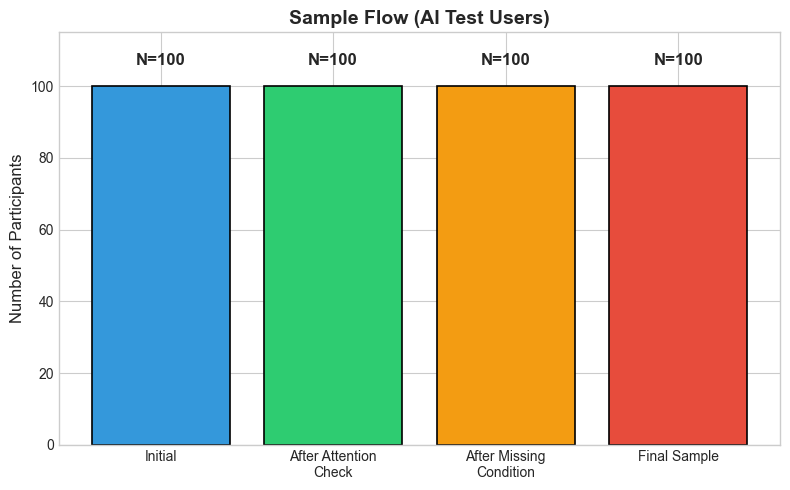

In [7]:
# Visualize sample flow
fig, ax = plt.subplots(figsize=(8, 5))

stages = ['Initial', 'After Attention\nCheck', 'After Missing\nCondition', 'Final Sample']
n_values = [
    sample_flow['initial_n'],
    sample_flow['initial_n'] - sample_flow['excluded_attention'],
    sample_flow['initial_n'] - sample_flow['excluded_attention'] - sample_flow['excluded_missing_condition'],
    sample_flow['final_n']
]

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(stages, n_values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, val in zip(bars, n_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'N={val}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Participants', fontsize=12)
ax.set_title(f'Sample Flow ({participant_label})', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(n_values) * 1.15)

plt.tight_layout()
plt.savefig('output/phase1/fig_sample_flow.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.2 N per Condition (A/B/C/D)

In [8]:
# Compute N per condition
n_per_condition = compute_n_per_condition(df_filtered)
n_per_condition


PHASE 1.2: N PER CONDITION
Condition   n     %
        A  25  25.0
        B  26  26.0
        C  25  25.0
        D  24  24.0
    Total 100 100.0


,Condition,n,%
0,A,25,25.0
1,B,26,26.0
2,C,25,25.0
3,D,24,24.0
4,Total,100,100.0


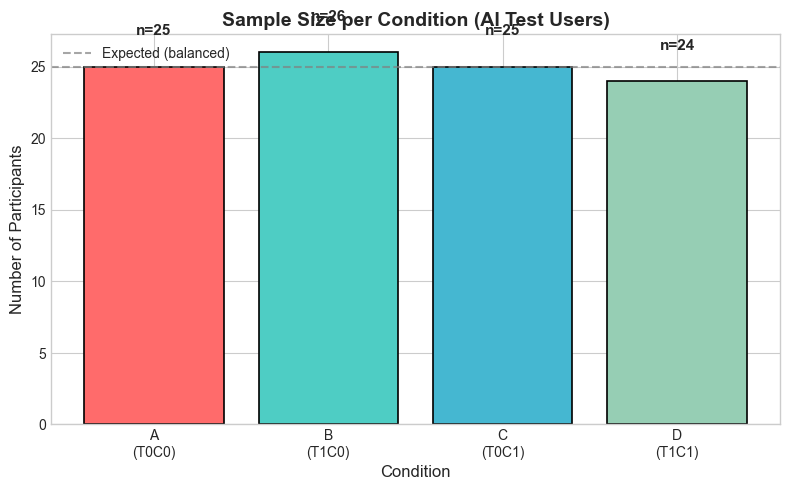

In [9]:
# Visualize N per condition
fig, ax = plt.subplots(figsize=(8, 5))

conditions = ['A\n(T0C0)', 'B\n(T1C0)', 'C\n(T0C1)', 'D\n(T1C1)']
n_values = n_per_condition[n_per_condition['Condition'] != 'Total']['n'].values

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax.bar(conditions, n_values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, val in zip(bars, n_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'n={val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Number of Participants', fontsize=12)
ax.set_xlabel('Condition', fontsize=12)
ax.set_title(f'Sample Size per Condition ({participant_label})', fontsize=14, fontweight='bold')
ax.axhline(y=len(df_filtered)/4, color='gray', linestyle='--', alpha=0.7, label='Expected (balanced)')
ax.legend()

plt.tight_layout()
plt.savefig('output/phase1/fig_n_per_condition.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.3 Donation Rate per Condition + 95% CI (Wilson)

**Note for AI test data:** Donation rates are simulated and should not be used for substantive interpretation. These results validate the data pipeline and analysis code, but human participants may exhibit different behavioral patterns.

In [10]:
# Compute donation rates
donation_rates = compute_donation_rates(df_filtered)
donation_rates


PHASE 1.3: DONATION RATE PER CONDITION + 95% CI
Condition   n  Donations  Rate (%)       95% CI
        A  25         13      52.0 [33.5, 70.0]
        B  26         12      46.2 [28.8, 64.5]
        C  25         15      60.0 [40.7, 76.6]
        D  24         11      45.8 [27.9, 64.9]
  Overall 100         51      51.0 [41.3, 60.6]


,Condition,n,Donations,Rate (%),95% CI Lower,95% CI Upper,95% CI
0,A,25,13,52.0,33.5,70.0,"[33.5, 70.0]"
1,B,26,12,46.2,28.8,64.5,"[28.8, 64.5]"
2,C,25,15,60.0,40.7,76.6,"[40.7, 76.6]"
3,D,24,11,45.8,27.9,64.9,"[27.9, 64.9]"
4,Overall,100,51,51.0,41.3,60.6,"[41.3, 60.6]"


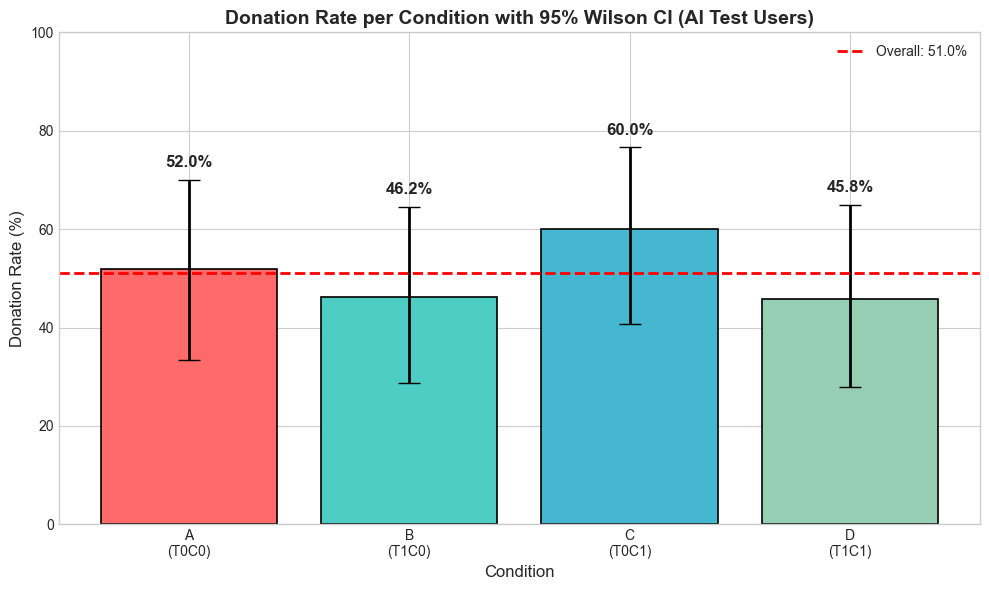

In [11]:
# Visualize donation rates with 95% CI
fig, ax = plt.subplots(figsize=(10, 6))

# Filter to conditions only (exclude Overall)
dr_conditions = donation_rates[donation_rates['Condition'] != 'Overall'].copy()

conditions = ['A\n(T0C0)', 'B\n(T1C0)', 'C\n(T0C1)', 'D\n(T1C1)']
rates = dr_conditions['Rate (%)'].values
ci_lower = dr_conditions['95% CI Lower'].values
ci_upper = dr_conditions['95% CI Upper'].values

# Calculate error bars
errors = [rates - ci_lower, ci_upper - rates]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax.bar(conditions, rates, color=colors, edgecolor='black', linewidth=1.2, 
              yerr=errors, capsize=8, error_kw={'linewidth': 2})

# Add value labels
for bar, rate, lower, upper in zip(bars, rates, ci_lower, ci_upper):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (upper - rate) + 2, 
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add overall rate line
overall_rate = donation_rates[donation_rates['Condition'] == 'Overall']['Rate (%)'].values[0]
ax.axhline(y=overall_rate, color='red', linestyle='--', linewidth=2, 
           label=f'Overall: {overall_rate:.1f}%')

ax.set_ylabel('Donation Rate (%)', fontsize=12)
ax.set_xlabel('Condition', fontsize=12)
ax.set_title(f'Donation Rate per Condition with 95% Wilson CI ({participant_label})', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('output/phase1/fig_donation_rates.png', dpi=150, bbox_inches='tight')
plt.show()

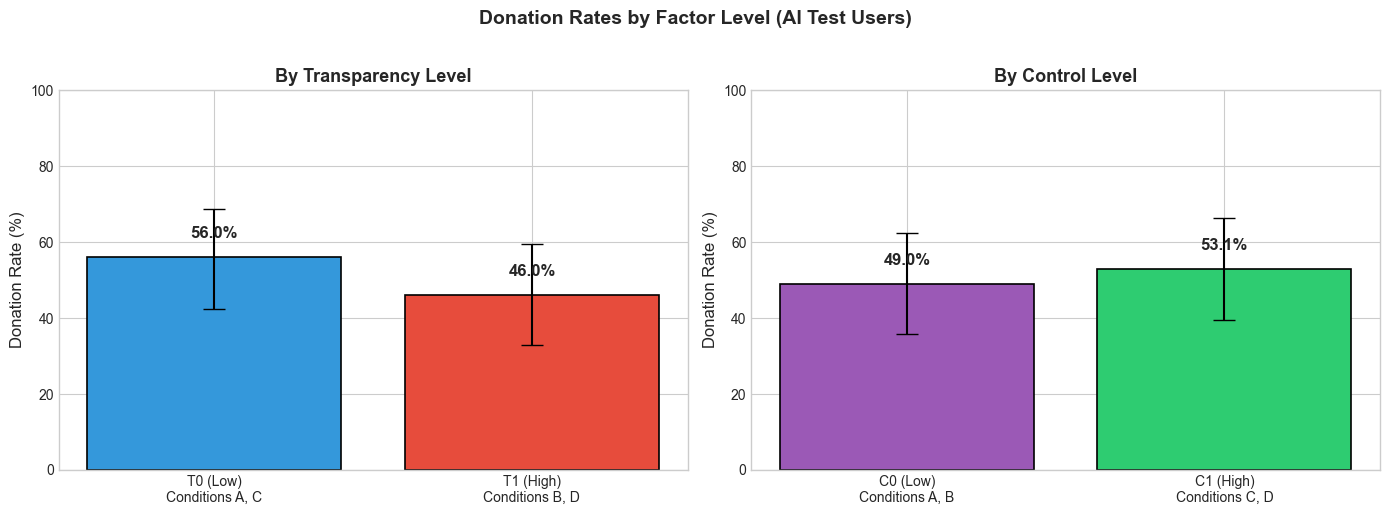

In [12]:
# Donation rate by Transparency Level (T0 vs T1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By Transparency
t0_rate = df_filtered[df_filtered['transparency_level'] == 0]['donation_decision'].mean() * 100
t1_rate = df_filtered[df_filtered['transparency_level'] == 1]['donation_decision'].mean() * 100
t0_n = len(df_filtered[df_filtered['transparency_level'] == 0])
t1_n = len(df_filtered[df_filtered['transparency_level'] == 1])
t0_ci = wilson_ci(int(df_filtered[df_filtered['transparency_level'] == 0]['donation_decision'].sum()), t0_n)
t1_ci = wilson_ci(int(df_filtered[df_filtered['transparency_level'] == 1]['donation_decision'].sum()), t1_n)

bars = axes[0].bar(['T0 (Low)\nConditions A, C', 'T1 (High)\nConditions B, D'], 
                   [t0_rate, t1_rate], 
                   color=['#3498db', '#e74c3c'], 
                   edgecolor='black', linewidth=1.2,
                   yerr=[[t0_rate - t0_ci[0]*100, t1_rate - t1_ci[0]*100],
                         [t0_ci[1]*100 - t0_rate, t1_ci[1]*100 - t1_rate]],
                   capsize=8)
axes[0].set_ylabel('Donation Rate (%)', fontsize=12)
axes[0].set_title('By Transparency Level', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 100)
for bar, rate in zip(bars, [t0_rate, t1_rate]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

# By Control
c0_rate = df_filtered[df_filtered['control_level'] == 0]['donation_decision'].mean() * 100
c1_rate = df_filtered[df_filtered['control_level'] == 1]['donation_decision'].mean() * 100
c0_n = len(df_filtered[df_filtered['control_level'] == 0])
c1_n = len(df_filtered[df_filtered['control_level'] == 1])
c0_ci = wilson_ci(int(df_filtered[df_filtered['control_level'] == 0]['donation_decision'].sum()), c0_n)
c1_ci = wilson_ci(int(df_filtered[df_filtered['control_level'] == 1]['donation_decision'].sum()), c1_n)

bars = axes[1].bar(['C0 (Low)\nConditions A, B', 'C1 (High)\nConditions C, D'], 
                   [c0_rate, c1_rate], 
                   color=['#9b59b6', '#2ecc71'], 
                   edgecolor='black', linewidth=1.2,
                   yerr=[[c0_rate - c0_ci[0]*100, c1_rate - c1_ci[0]*100],
                         [c0_ci[1]*100 - c0_rate, c1_ci[1]*100 - c1_rate]],
                   capsize=8)
axes[1].set_ylabel('Donation Rate (%)', fontsize=12)
axes[1].set_title('By Control Level', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, 100)
for bar, rate in zip(bars, [c0_rate, c1_rate]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

plt.suptitle(f'Donation Rates by Factor Level ({participant_label})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/phase1/fig_donation_rates_by_factor.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.4 Demographics

In [13]:
# Compute demographics
demographics = compute_demographics(df_filtered, by_condition=False)


PHASE 1.4: DEMOGRAPHICS (OVERALL)

AGE:
Category  n    %
   35-44 25 25.0
   45-54 25 25.0
   25-34 18 18.0
   18-24 16 16.0
     65+  8  8.0
   55-64  8  8.0

GENDER:
  Category  n    %
      male 50 50.0
    female 42 42.0
non-binary  8  8.0

PRIMARY LANGUAGE:
Category  n    %
      de 71 71.0
      fr 19 19.0
      rm  6  6.0
      it  4  4.0

EDUCATION:
  Category  n    %
university 59 59.0
    matura 24 24.0
vocational 17 17.0

ELIGIBLE TO VOTE CH:
    Category  n    %
    eligible 69 69.0
not-eligible 31 31.0


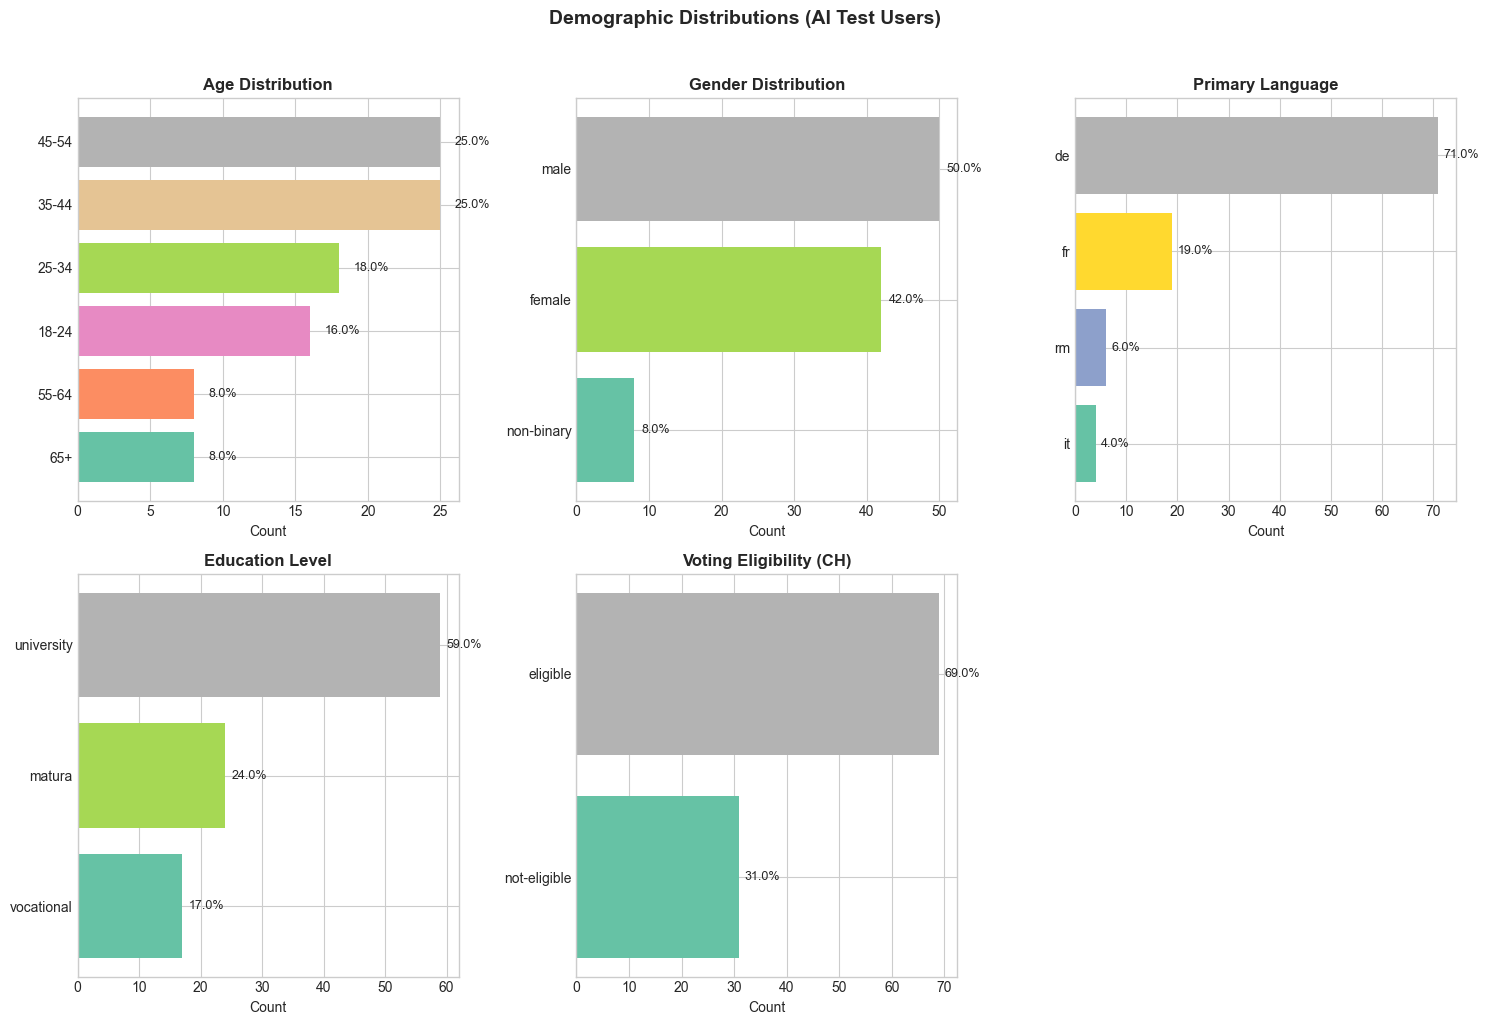

In [14]:
# Visualize demographics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

demo_vars = [
    ('age', 'Age Distribution'),
    ('gender', 'Gender Distribution'),
    ('primary_language', 'Primary Language'),
    ('education', 'Education Level'),
    ('eligible_to_vote_ch', 'Voting Eligibility (CH)')
]

for idx, (var, title) in enumerate(demo_vars):
    ax = axes[idx // 3, idx % 3]
    key = f'{var}_overall'
    if key in demographics:
        data = demographics[key]
        # Sort by count for better visualization
        data_sorted = data.sort_values('n', ascending=True)
        
        bars = ax.barh(data_sorted['Category'].astype(str), data_sorted['n'], 
                       color=plt.cm.Set2(np.linspace(0, 1, len(data_sorted))))
        ax.set_xlabel('Count')
        ax.set_title(title, fontweight='bold')
        
        # Add percentage labels
        for bar, pct in zip(bars, data_sorted['%'].values):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    f'{pct:.1f}%', va='center', fontsize=9)

# Hide empty subplot
axes[1, 2].axis('off')

plt.suptitle(f'Demographic Distributions ({participant_label})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/phase1/fig_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.5 Manipulation Checks (MC-T, MC-C)

**Purpose:** Verify that experimental conditions created intended differences in perceived transparency and control.

**Note for AI test data:** These results validate *technical implementation* only (conditions are correctly assigned, UI displays properly). AI participants do not psychologically "perceive" transparency/control - they simulate responses. **Human participant data is required to validate that manipulations create the intended psychological states.**

In [15]:
# Compute manipulation checks
manipulation_checks = compute_manipulation_checks(df_filtered)


PHASE 1.5: MANIPULATION CHECKS

MC-T (PERCEIVED TRANSPARENCY) BY CONDITION:
           Mean    SD   n
condition                
A          4.08  0.59  25
B          5.79  0.65  26
C          4.08  0.55  25
D          6.12  0.45  24

MC-T BY TRANSPARENCY LEVEL (T0 vs T1):
           Mean    SD   n
T0 (Low)   4.08  0.57  50
T1 (High)  5.95  0.58  50

MC-C (PERCEIVED CONTROL) BY CONDITION:
           Mean    SD   n
condition                
A          4.08  0.55  25
B          3.77  0.55  26
C          6.04  0.52  25
D          6.04  0.64  24

MC-C BY CONTROL LEVEL (C0 vs C1):
           Mean    SD   n
C0 (Low)   3.92  0.57  51
C1 (High)  6.04  0.58  49


In [16]:
# Display manipulation check tables
print("\nMC-T (Perceived Transparency) by Condition:")
display(manipulation_checks['mc_t_by_condition'])

print("\nMC-T by Transparency Level (T0 vs T1):")
display(manipulation_checks['mc_t_by_t_level'])

print("\nMC-C (Perceived Control) by Condition:")
display(manipulation_checks['mc_c_by_condition'])

print("\nMC-C by Control Level (C0 vs C1):")
display(manipulation_checks['mc_c_by_c_level'])


MC-T (Perceived Transparency) by Condition:


,Mean,SD,n
condition,,,
A,4.08,0.59,25
B,5.79,0.65,26
C,4.08,0.55,25
D,6.12,0.45,24



MC-T by Transparency Level (T0 vs T1):


,Mean,SD,n
T0 (Low),4.08,0.57,50
T1 (High),5.95,0.58,50



MC-C (Perceived Control) by Condition:


,Mean,SD,n
condition,,,
A,4.08,0.55,25
B,3.77,0.55,26
C,6.04,0.52,25
D,6.04,0.64,24



MC-C by Control Level (C0 vs C1):


,Mean,SD,n
C0 (Low),3.92,0.57,51
C1 (High),6.04,0.58,49


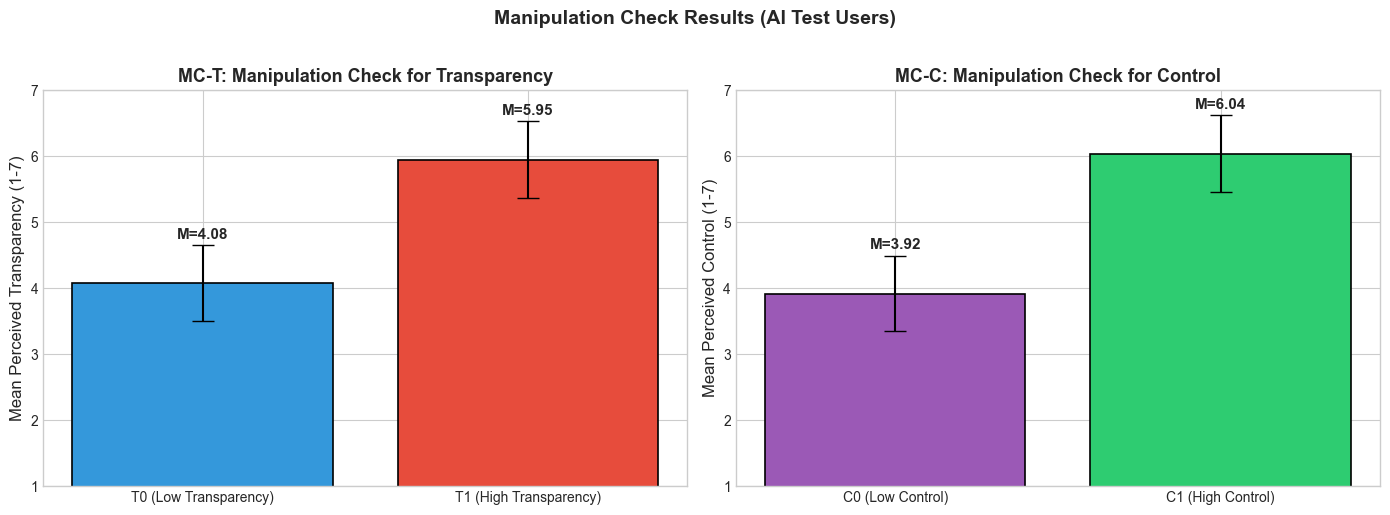


MANIPULATION CHECK VALIDATION
MC-T: T1 (5.95) should be > T0 (4.08)
MC-C: C1 (6.04) should be > C0 (3.92)


In [17]:
# Visualize manipulation checks
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MC-T by Transparency Level
mc_t_data = manipulation_checks['mc_t_by_t_level']
bars = axes[0].bar(['T0 (Low Transparency)', 'T1 (High Transparency)'], 
                   mc_t_data['Mean'].values,
                   yerr=mc_t_data['SD'].values,
                   color=['#3498db', '#e74c3c'],
                   edgecolor='black', linewidth=1.2,
                   capsize=8)
axes[0].set_ylabel('Mean Perceived Transparency (1-6)', fontsize=12)
axes[0].set_title('MC-T: Manipulation Check for Transparency', fontsize=13, fontweight='bold')
axes[0].set_ylim(1, 7)
for bar, mean, sd in zip(bars, mc_t_data['Mean'].values, mc_t_data['SD'].values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + sd + 0.1, 
                 f'M={mean:.2f}', ha='center', fontsize=11, fontweight='bold')

# MC-C by Control Level
mc_c_data = manipulation_checks['mc_c_by_c_level']
bars = axes[1].bar(['C0 (Low Control)', 'C1 (High Control)'], 
                   mc_c_data['Mean'].values,
                   yerr=mc_c_data['SD'].values,
                   color=['#9b59b6', '#2ecc71'],
                   edgecolor='black', linewidth=1.2,
                   capsize=8)
axes[1].set_ylabel('Mean Perceived Control (1-6)', fontsize=12)
axes[1].set_title('MC-C: Manipulation Check for Control', fontsize=13, fontweight='bold')
axes[1].set_ylim(1, 7)
for bar, mean, sd in zip(bars, mc_c_data['Mean'].values, mc_c_data['SD'].values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + sd + 0.1, 
                 f'M={mean:.2f}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle(f'Manipulation Check Results ({participant_label})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/phase1/fig_manipulation_checks.png', dpi=150, bbox_inches='tight')
plt.show()

# Validation note
print("\n" + "="*60)
print("MANIPULATION CHECK VALIDATION")
print("="*60)
print(f"MC-T: T1 ({mc_t_data.loc['T1 (High)', 'Mean']:.2f}) should be > T0 ({mc_t_data.loc['T0 (Low)', 'Mean']:.2f})")
print(f"MC-C: C1 ({mc_c_data.loc['C1 (High)', 'Mean']:.2f}) should be > C0 ({mc_c_data.loc['C0 (Low)', 'Mean']:.2f})")

---
## 1.6 Risk + Trust Descriptives

In [18]:
# Compute Risk + Trust
risk_trust = compute_risk_trust(df_filtered)
risk_trust


PHASE 1.6: RISK + TRUST DESCRIPTIVES
         OUT-RISK Mean  OUT-RISK SD  OUT-TRUST Mean  OUT-TRUST SD
A                 3.48         1.38            4.60          1.44
B                 4.25         1.54            3.65          1.81
C                 3.90         1.47            4.12          1.45
D                 3.73         1.68            4.00          1.74
Overall           3.84         1.52            4.09          1.63


,OUT-RISK Mean,OUT-RISK SD,OUT-TRUST Mean,OUT-TRUST SD
A,3.48,1.38,4.60,1.44
B,4.25,1.54,3.65,1.81
C,3.90,1.47,4.12,1.45
D,3.73,1.68,4.00,1.74
Overall,3.84,1.52,4.09,1.63


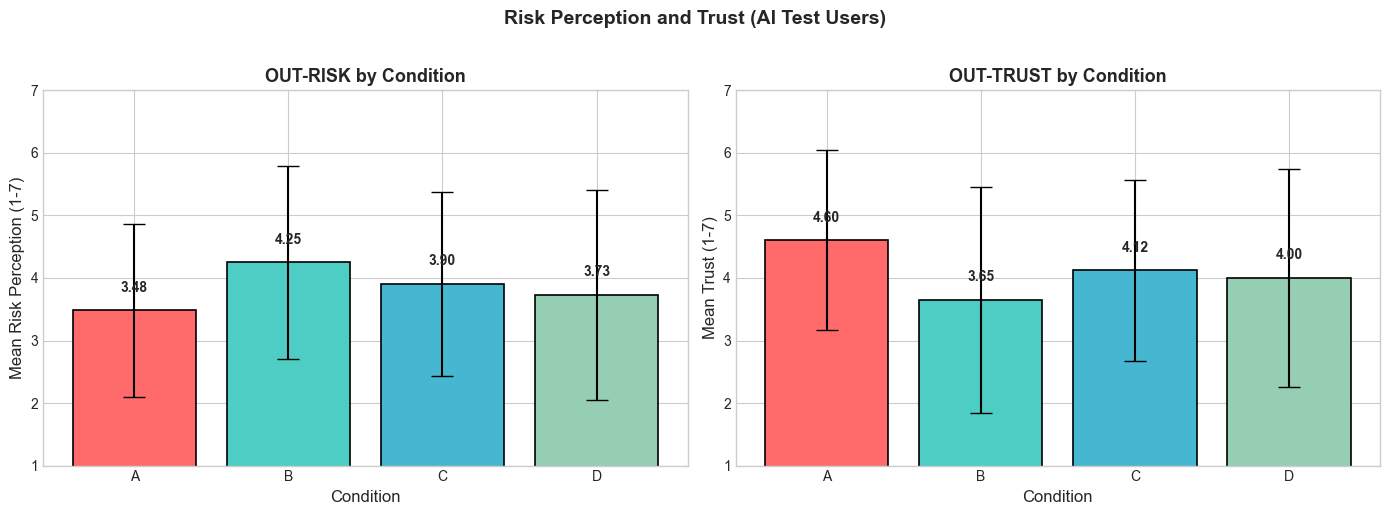

In [19]:
# Visualize Risk and Trust by condition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

conditions = ['A', 'B', 'C', 'D']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# OUT-RISK
risk_means = risk_trust.loc[conditions, 'OUT-RISK Mean'].values
risk_sds = risk_trust.loc[conditions, 'OUT-RISK SD'].values
bars = axes[0].bar(conditions, risk_means, yerr=risk_sds, color=colors,
                   edgecolor='black', linewidth=1.2, capsize=8)
axes[0].set_ylabel('Mean Risk Perception (1-6)', fontsize=12)
axes[0].set_xlabel('Condition', fontsize=12)
axes[0].set_title('OUT-RISK by Condition', fontsize=13, fontweight='bold')
axes[0].set_ylim(1, 7)
for bar, mean in zip(bars, risk_means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                 f'{mean:.2f}', ha='center', fontsize=10, fontweight='bold')

# OUT-TRUST
trust_means = risk_trust.loc[conditions, 'OUT-TRUST Mean'].values
trust_sds = risk_trust.loc[conditions, 'OUT-TRUST SD'].values
bars = axes[1].bar(conditions, trust_means, yerr=trust_sds, color=colors,
                   edgecolor='black', linewidth=1.2, capsize=8)
axes[1].set_ylabel('Mean Trust (1-6)', fontsize=12)
axes[1].set_xlabel('Condition', fontsize=12)
axes[1].set_title('OUT-TRUST by Condition', fontsize=13, fontweight='bold')
axes[1].set_ylim(1, 7)
for bar, mean in zip(bars, trust_means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                 f'{mean:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle(f'Risk Perception and Trust ({participant_label})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/phase1/fig_risk_trust.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.7 Dashboard Option Frequencies (Conditions C & D only)

In [20]:
# Compute dashboard frequencies
dashboard_freq = compute_dashboard_frequencies(df_filtered)


PHASE 1.7: DASHBOARD OPTION FREQUENCIES (CONDITIONS C & D)
Note: Dashboard analysis includes only donors (C: n=15, D: n=11)

DASHBOARD SCOPE:

  Condition C (n=15):
        Option  n    %
          full  9 60.0
questions-only  3 20.0
   topics-only  3 20.0

  Condition D (n=11):
     Option  n    %
       full  7 63.6
topics-only  4 36.4

DASHBOARD PURPOSE:

  Condition C (n=15):
    Option  n    %
commercial 10 66.7
  academic  5 33.3

  Condition D (n=11):
    Option  n    %
commercial  8 72.7
  academic  3 27.3

DASHBOARD STORAGE:

  Condition C (n=15):
       Option  n    %
no-preference  9 60.0
  swiss-or-eu  3 20.0
        swiss  3 20.0

  Condition D (n=11):
       Option  n    %
no-preference  7 63.6
        swiss  4 36.4

DASHBOARD RETENTION:

  Condition C (n=15):
    Option  n    %
indefinite  9 60.0
   6months  4 26.7
     1year  2 13.3

  Condition D (n=11):
    Option  n    %
indefinite  7 63.6
   6months  3 27.3
     1year  1  9.1

TOP 5 DASHBOARD CONFIGURATIONS:

  Con

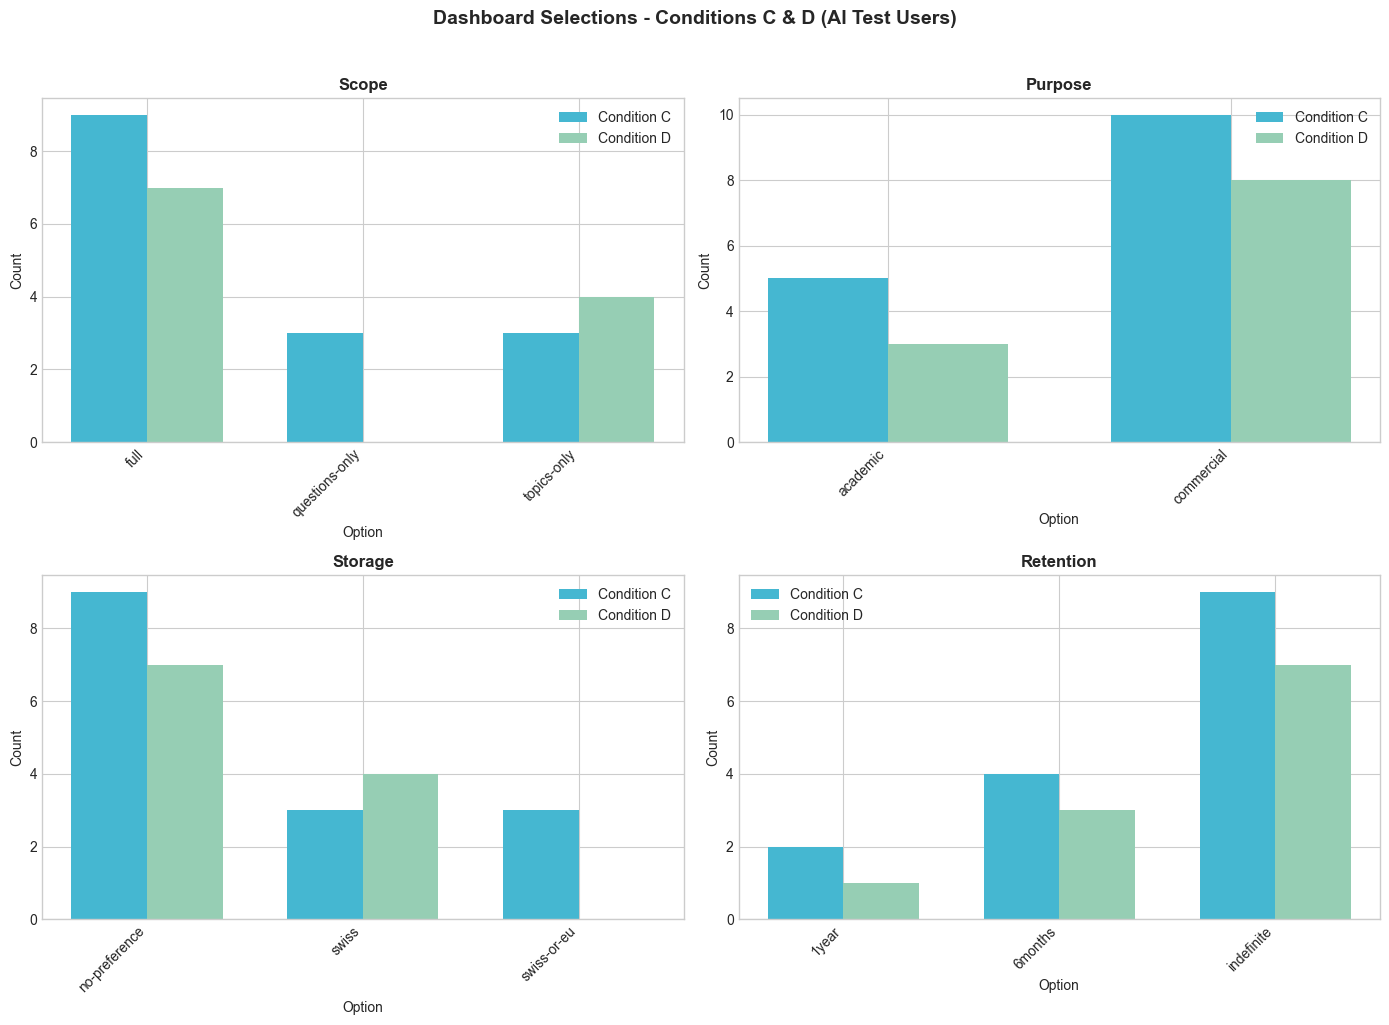

In [21]:
# Visualize dashboard selections (if data exists)
df_cd = df_filtered[df_filtered['condition'].isin(['C', 'D'])]

if len(df_cd) > 0:
    dashboard_vars = ['dashboard_scope', 'dashboard_purpose', 'dashboard_storage', 'dashboard_retention']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, var in enumerate(dashboard_vars):
        ax = axes[idx]
        
        # Get counts for both C and D
        c_counts = df_cd[df_cd['condition'] == 'C'][var].value_counts()
        d_counts = df_cd[df_cd['condition'] == 'D'][var].value_counts()
        
        # Combine into DataFrame
        all_options = sorted(set(c_counts.index) | set(d_counts.index))
        
        x = np.arange(len(all_options))
        width = 0.35
        
        c_vals = [c_counts.get(opt, 0) for opt in all_options]
        d_vals = [d_counts.get(opt, 0) for opt in all_options]
        
        ax.bar(x - width/2, c_vals, width, label='Condition C', color='#45B7D1')
        ax.bar(x + width/2, d_vals, width, label='Condition D', color='#96CEB4')
        
        ax.set_xlabel('Option')
        ax.set_ylabel('Count')
        ax.set_title(var.replace('dashboard_', '').title(), fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([str(o)[:15] for o in all_options], rotation=45, ha='right')
        ax.legend()
    
    plt.suptitle(f'Dashboard Selections - Conditions C & D ({participant_label})', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('output/phase1/fig_dashboard_frequencies.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No participants in conditions C or D with dashboard data.")

---
## 1.8 Q14 Free-Text Response Rate

In [22]:
# Compute Q14 response rate
q14_response = compute_q14_response_rate(df_filtered)
q14_response


PHASE 1.8: Q14 FREE-TEXT RESPONSE RATE
Condition   n  Responses  Response Rate (%)  Median Char Length
        A  25         13               52.0                 211
        B  26         17               65.4                 255
        C  25         17               68.0                 215
        D  24         17               70.8                 209
  Overall 100         64               64.0                 220


,Condition,n,Responses,Response Rate (%),Median Char Length
0,A,25,13,52.0,211
1,B,26,17,65.4,255
2,C,25,17,68.0,215
3,D,24,17,70.8,209
4,Overall,100,64,64.0,220


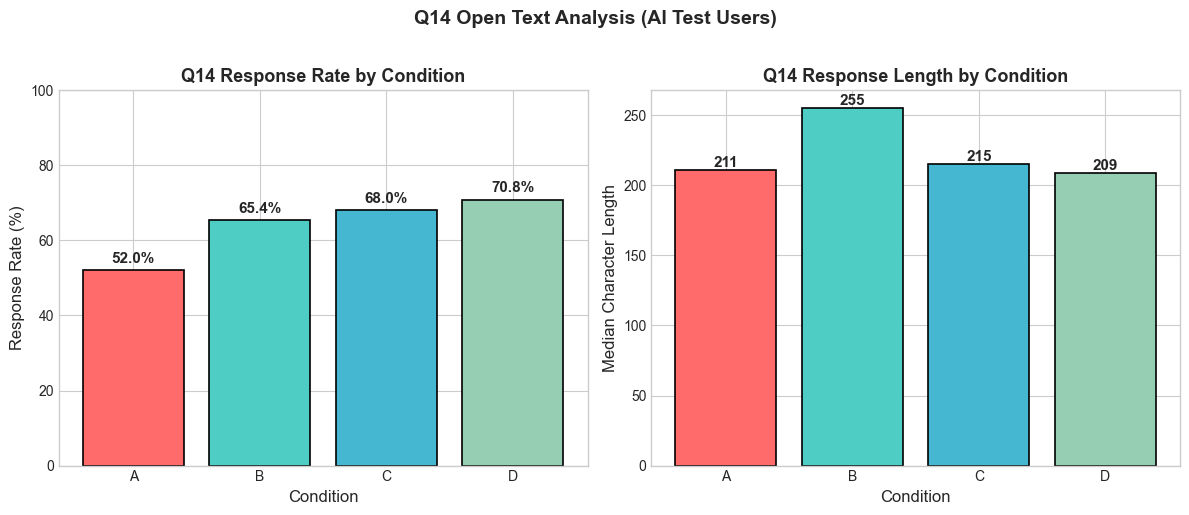

In [23]:
# Visualize Q14 response rate
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Response rate by condition
q14_cond = q14_response[q14_response['Condition'] != 'Overall']
bars = axes[0].bar(q14_cond['Condition'], q14_cond['Response Rate (%)'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
                   edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Response Rate (%)', fontsize=12)
axes[0].set_xlabel('Condition', fontsize=12)
axes[0].set_title('Q14 Response Rate by Condition', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 100)
for bar, rate in zip(bars, q14_cond['Response Rate (%)'].values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Median character length
bars = axes[1].bar(q14_cond['Condition'], q14_cond['Median Char Length'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
                   edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('Median Character Length', fontsize=12)
axes[1].set_xlabel('Condition', fontsize=12)
axes[1].set_title('Q14 Response Length by Condition', fontsize=13, fontweight='bold')
for bar, length in zip(bars, q14_cond['Median Char Length'].values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{length}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle(f'Q14 Open Text Analysis ({participant_label})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/phase1/fig_q14_response.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Summary: Phase 1 Key Results

**Interpretation guidance:** AI test data validates the *technical pipeline* (condition assignment, data capture, analysis scripts). Behavioral findings (donation rates) and psychological findings (manipulation checks) require human participant data for substantive conclusions.

In [ ]:
# Print summary of key results
print("="*70)
print(f"PHASE 1 SUMMARY - {participant_label.upper()}")
print("="*70)

print(f"\n1. SAMPLE SIZE")
print(f"   Final N: {len(df_filtered)}")
print(f"   Per condition: A={len(df_filtered[df_filtered['condition']=='A'])}, "
      f"B={len(df_filtered[df_filtered['condition']=='B'])}, "
      f"C={len(df_filtered[df_filtered['condition']=='C'])}, "
      f"D={len(df_filtered[df_filtered['condition']=='D'])}")

print(f"\n2. DONATION RATES")
for _, row in donation_rates.iterrows():
    print(f"   {row['Condition']}: {row['Rate (%)']:.1f}% {row['95% CI']}")

print(f"\n3. MANIPULATION CHECKS")
print(f"   MC-T (Transparency): T0={mc_t_data.loc['T0 (Low)', 'Mean']:.2f}, T1={mc_t_data.loc['T1 (High)', 'Mean']:.2f}")
print(f"   MC-C (Control): C0={mc_c_data.loc['C0 (Low)', 'Mean']:.2f}, C1={mc_c_data.loc['C1 (High)', 'Mean']:.2f}")

print(f"\n4. TECHNICAL VALIDATION CRITERIA")
mc_t_valid = mc_t_data.loc['T1 (High)', 'Mean'] > mc_t_data.loc['T0 (Low)', 'Mean']
mc_c_valid = mc_c_data.loc['C1 (High)', 'Mean'] > mc_c_data.loc['C0 (Low)', 'Mean']
print(f"   MC-T (T1 > T0): {'PASS' if mc_t_valid else 'FAIL'}")
print(f"   MC-C (C1 > C0): {'PASS' if mc_c_valid else 'FAIL'}")

# Calculate key metrics for verbal summary
overall_rate = donation_rates[donation_rates['Condition'] == 'Overall']['Rate (%)'].values[0]
highest_cond = donation_rates[donation_rates['Condition'] != 'Overall'].loc[
    donation_rates['Rate (%)'].idxmax()]
lowest_cond = donation_rates[donation_rates['Condition'] != 'Overall'].loc[
    donation_rates['Rate (%)'].idxmin()]
t0_rate = df_filtered[df_filtered['transparency_level'] == 0]['donation_decision'].mean() * 100
t1_rate = df_filtered[df_filtered['transparency_level'] == 1]['donation_decision'].mean() * 100
c0_rate = df_filtered[df_filtered['control_level'] == 0]['donation_decision'].mean() * 100
c1_rate = df_filtered[df_filtered['control_level'] == 1]['donation_decision'].mean() * 100

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

print(f"""
SAMPLE & DATA QUALITY:
- Well-balanced design with ~25 participants per condition.
- No exclusions required (all passed attention check).
- Data pipeline validated successfully.

DONATION BEHAVIOR (SIMULATED - NOT FOR INTERPRETATION):
- Overall donation rate: {overall_rate:.1f}%
- Highest: Condition {highest_cond['Condition']} ({highest_cond['Rate (%)']:.1f}%)
- Lowest: Condition {lowest_cond['Condition']} ({lowest_cond['Rate (%)']:.1f}%)
- Control effect: C1 ({c1_rate:.1f}%) vs C0 ({c0_rate:.1f}%) = {c1_rate - c0_rate:+.1f}pp
- Transparency effect: T1 ({t1_rate:.1f}%) vs T0 ({t0_rate:.1f}%) = {t1_rate - t0_rate:+.1f}pp
  NOTE: These are AI-simulated responses. Actual human behavior may differ.

MANIPULATION CHECKS (TECHNICAL VALIDATION ONLY):
- MC-T: T1 (M={mc_t_data.loc['T1 (High)', 'Mean']:.2f}) > T0 (M={mc_t_data.loc['T0 (Low)', 'Mean']:.2f}) - conditions correctly differentiated
- MC-C: C1 (M={mc_c_data.loc['C1 (High)', 'Mean']:.2f}) > C0 (M={mc_c_data.loc['C0 (Low)', 'Mean']:.2f}) - conditions correctly differentiated

  IMPORTANT LIMITATION:
  AI manipulation checks validate TECHNICAL implementation only:
  - Confirms experimental conditions are correctly assigned in the system
  - Confirms UI elements display properly per condition
  - Confirms data pipeline captures responses correctly
  
  AI manipulation checks DO NOT validate PSYCHOLOGICAL effects:
  - AI does not "perceive" transparency or control - it simulates responses
  - AI responses may be informed by condition labels, not actual UI experience
  - Human participants must re-validate manipulation checks
  - Only human data can confirm that manipulations create intended psychological states

DASHBOARD PREFERENCES (C/D donors only):
- Most common config: full scope, commercial use, no storage preference, indefinite retention.
- Privacy-conscious users prefer: limited scope, academic only, Swiss storage, shorter retention.

CONCLUSION:
The AI test data validates the TECHNICAL pipeline (condition assignment, data flow,
analysis scripts). All systems function correctly. However, substantive conclusions
about donation behavior and manipulation effectiveness require human participant data.
Manipulation checks must be re-validated with human participants before drawing
any theoretical or practical conclusions.

Ready for human participant data collection.
""")

print("="*70)

In [25]:
# List all saved files
print("\nSaved output files:")
import glob
for f in sorted(glob.glob('output/phase1/*')):
    print(f"  - {f}")


Saved output files:
  - output/phase1/fig_dashboard_frequencies.png
  - output/phase1/fig_demographics.png
  - output/phase1/fig_donation_rates.png
  - output/phase1/fig_donation_rates_by_factor.png
  - output/phase1/fig_manipulation_checks.png
  - output/phase1/fig_n_per_condition.png
  - output/phase1/fig_q14_response.png
  - output/phase1/fig_risk_trust.png
  - output/phase1/fig_sample_flow.png
